In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [62]:
import os
import math
import time
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from data.othello import Othello, OthelloBoardState, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.utils import sample
from mingpt.model import GPT, GPTConfig
from mingpt.trainer import Trainer, TrainerConfig

## Training

In [ ]:
# n_games=-1 means use as many simulated games as possible (from "data/othello_synthetic/")
othello = Othello(n_games=1000, data_root="othello_topleftbias80")
train_dataset = CharDataset(othello)
# original OthelloGPT params: n_layer=8, n_head=8, n_embd=512
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf)

In [5]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)
else:
    print("NO GPU FOUND")

In [6]:
# setting up training
max_epochs = 40
experiment_name = "unbiased_e40"
t_start = time.strftime("_%Y%m%d_%H%M%S")
ckpt_path = f"./ckpts/{experiment_name}_{t_start}.ckpt"
tconf = TrainerConfig(
    max_epochs=max_epochs, 
    batch_size=512*4, # using 4 gpus
    learning_rate=5e-4,
    lr_decay=True, 
    warmup_tokens=len(train_dataset)*train_dataset.block_size*5, 
    final_tokens=len(train_dataset)*train_dataset.block_size*max_epochs,
    num_workers=0, 
    ckpt_path=ckpt_path, 
    # saved_epochs=[0, 1, 2, 3, 5, 10, 15, 20],
)
trainer = Trainer(model, train_dataset, None, tconf)
device = trainer.device
print(t_start)

_20230704_210935


In [ ]:
trainer.train()

In [18]:
# loading model from ckpt
# ckpt = "grok/synth"
ckpt = "bias/TLbias95"
load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt}.ckpt"))
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)
else:
    print("NO GPU FOUND")

## Validation

In [26]:
# checks if model prediction is legal for each node in given game
# expects dataset has already been loaded and model is on GPU
def check_legal(model, device, train_dataset, game):
    total_nodes = 0
    success_nodes = 0

    len_whole_game = len(game)
    for len_partial_game in range(1, len_whole_game):
        total_nodes += 1
        context = game[:len_partial_game]
        x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None, ...].to(device)
        y = sample(model, x, 1, temperature=1.0)
        # taking top-1 prediction
        completion = [train_dataset.itos[int(i)] for i in y[0] if i != -1]
        try:
            OthelloBoardState().update(completion)
        except Exception:
            pass
        else:
            success_nodes += 1
    
    return total_nodes, success_nodes

In [27]:
# default data root is othello_synthetic
def validate_with_dataset(model, device, data_root=None, n_games=1000):
    # find to load in first n games, because the first ~1 million othello_synthetic games are test set for unbiased model
    val_games = Othello(data_root=data_root, n_games=n_games, test_split=1)
    char = CharDataset(val_games.val)

    total_nodes = 0
    success_nodes = 0

    def progress_report():
        return f"{success_nodes/total_nodes*100:.4f}% pass rate: {success_nodes}/{total_nodes} among all searched nodes"
    
    bar = tqdm(val_games.val[:n_games])
    for game in bar:
        tn, sn = check_legal(model, device, game, char)
        total_nodes += tn
        success_nodes += sn
        bar.set_description(progress_report())
    print(progress_report())

In [28]:
def load_othello_model(ckpt):
    # original OthelloGPT params: n_layer=8, n_head=8, n_embd=512
    # vocab_size = 59, block_size = 61 for othello
    mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)
    model = GPT(mconf)
    load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt}.ckpt"))
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        model = model.to(device)
        return model, device
    else:
        print("NO GPU FOUND")

In [29]:
def validate_from_checkpoint(ckpt, data_root=None, n_games=1000):
    model, device = load_othello_model(ckpt)
    validate_with_dataset(model, device, data_root=data_root, n_games=n_games)

In [ ]:
for c in ["bias/TLcontrol", "bias/TLbias50", "bias/TLbias80", "bias/TLbias95"]:
    # for dr in ["synthetic", "topleftbias50", "topleftbias80", "topleftbias95"]:
    for dr in ["topleftbias50", "topleftbias80", "topleftbias95"]:
        print("========", c, dr)
        validate_from_checkpoint(c, data_root=f"othello_{dr}", n_games=50)

## Visualizing Predictions

In [78]:
model, device = load_othello_model("bias/TLbias80")

In [79]:
ex_games = Othello(data_root="othello_synthetic", n_games=5, test_split=1)
train_dataset = CharDataset(ex_games.val)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.212 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 99999 from 1 files. Now deduplicating...
Deduplicating finished with 5 games left
Using 0 for training, 5 for validation
Dataset created has 5 sequences, 61 unique words.


In [80]:
partial_game = ex_games.val[0][:7]
ob = OthelloBoardState()
ob.update(partial_game)
ob.__print__()
print([permit_reverse(x) for x in ob.get_valid_moves()])

--------------------
['c4', 'c3', 'd3', 'e3', 'f5', 'c6', 'c2']
a                
b                
c   X X X   O    
d     X X O      
e     O X X      
f         X      
g                
h                
  1 2 3 4 5 6 7 8
--------------------
['b3', 'c5', 'd2', 'e6', 'f3', 'g5']


In [81]:
# load partial game onto GPU
history = torch.tensor([train_dataset.stoi[s] for s in partial_game], dtype=torch.long).to(device)
# get model prediction
pred, _ = model(history[None, :]) 
# transform into probability for each board state
pred = pred[0, -1, 1:]
padding = torch.zeros(2).cuda()
pred = torch.softmax(pred, dim=0)
pred = torch.cat([pred[:27], padding, pred[27:33], padding, pred[33:]], dim=0)

<AxesSubplot:>

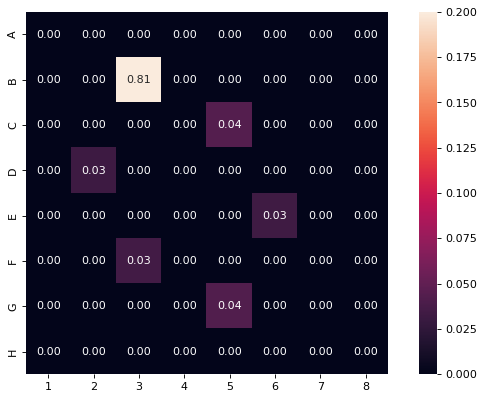

In [82]:
# plotting
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
vv = 0.2
sns.heatmap(pred.detach().cpu().numpy().reshape(8, 8), vmin=0., vmax=vv, 
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")

### probe analysis

In [1]:
# summarizing probe loss

import json

root = f"ckpts/grok/probes/state_tl256_random"
errs = []
for i in range(8):
    name = f"layer{i+1}/tensorboard.txt"
    with open(f"{root}/{name}", "r") as file:
        j = json.load(file)
        test_acc = j['test_acc_cont']
        err = 100 * (1 - test_acc[-1])
        errs.append(err)
        # print(f"layer {i+1} error rate: {err:.5f}")

print(", ".join([str(e) for e in errs]))

25.944670627934276, 25.998496185446008, 26.326511150234744, 26.59829812206572, 26.910798122065728, 26.979478433098592, 27.150491490610328, 27.355670481220663
